In [ ]:
import torch
from torch import Tensor
from torch.nn import functional as F
from torch import nn
from torch.distributions.categorical import Categorical
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm

## Discrete Case Helper Functions

In [ ]:
def dis_beta_t(beta_1, t):
  assert torch.all(t <= 1.0), "all times in `t` must be at most 1"
  assert torch.all(t >= 0.0), "all times in `t` must be at least 0"
  return beta_1 * (t**2)

def dis_y_distribution(beta: Tensor, K: int, kron_x: Tensor):
  beta_reshaped = beta.view(-1, 1, 1)
  mean = beta_reshaped * (K * kron_x - 1)
  variance = beta_reshaped * K
  eps = torch.normal(0, 1, kron_x.shape, device=beta.device)
  return mean + variance * eps

def dis_t(i: Tensor, n: Tensor, minimum: float=1e-6):
  assert torch.all(i <= n), "i must be less than or equal to n"
  assert torch.all(n > 0), "n must be at least 1"
  assert torch.all(i > 0), "i must be at least 1"
  return torch.clamp((i - 1) / n, min=minimum)

def dis_theta(y_prime, scaled=True):
  theta = F.softmax(y_prime, dim=-1)
  if scaled:
    theta = 2 * theta - 1
  return theta

def dis_loss(K: int, beta_1: Tensor, t: Tensor, batch_size: int, truth: Tensor, model_output_probs: Tensor | None = None, model_output_logits: Tensor | None = None):
  """
  Can accept either the raw model output in the form of logits or a softmax
  version of the model output. Only one of the two should be given, if both
  are given, will fail assertion
  """
  assert model_output_probs is None or model_output_logits is None, "Give only model output in the form of logits or probability distribution, not both"
  assert (model_output_probs is None or model_output_probs.shape == truth.shape) and (model_output_logits is None or model_output_logits.shape == truth.shape), "Model output shape should match that of ground truth"

  batch_size, seq_len, classes = truth.shape
  model_output = model_output_probs if model_output_probs is not None else torch.softmax(model_output_logits, dim=-1)
  result = torch.sum(K * beta_1 * t * torch.sum((truth - model_output) ** 2) / (batch_size**2))
  return result / seq_len

## Discrete case input data

In [ ]:
discrete_truth_1 = torch.tensor([
    [
        0, 1, 0
    ],
    [
        1, 0, 0
    ]
])
discrete_truth_2 = torch.tensor([
    [
        0, 0, 1
    ],
    [
        0, 1, 0
    ]
])
discrete_truth = torch.stack([discrete_truth_1, discrete_truth_2])

dis_batch_size, dis_seq_len, K = discrete_truth.shape

dis_beta_1 = torch.tensor([4, 3])

n = torch.tensor([10, 12])
i = torch.tensor([1, 3])

t = dis_t(i, n)

beta = dis_beta_t(dis_beta_1, t)

y_prime = dis_y_distribution(beta, K, discrete_truth)

theta = dis_theta(y_prime)

## Discrete case model

In [ ]:
class DiscreteModel(nn.Module):
  def __init__(self, max_seq_len: int, K: int, hidden_dim: int, num_heads: int, layers: int = 3, dropout: float = 0.1):
    super().__init__()
    assert hidden_dim % num_heads == 0, "hidden_dim must be divisble by num_heads"
    self.emb = nn.Parameter(torch.randn(K, hidden_dim))
    self.pos_emb = nn.Parameter(torch.randn(max_seq_len, hidden_dim))
    self.time_vec = nn.Parameter(torch.randn(1, hidden_dim))
    self.layers = nn.ModuleList(
        [
            nn.TransformerEncoderLayer(
                hidden_dim,
                num_heads,
                hidden_dim*4,
                dropout,
                batch_first=True,
                bias=False
                ) for i in range(layers)
        ]
    )
    self.classifier = nn.Parameter(torch.randn(hidden_dim, K))

  def token_emb(self, x):
    return x @ self.emb

  def positional_emb(self, x):
    return x + self.pos_emb[:x.shape[1]]

  def time_emb(self, x, t):
    assert t.ndim == 1, "time vector `t` should be vector of length batch_size"
    # we need to first unsqueeze t to get it from shape (batch_size,)
    # to (batch_size, 1) so it is compatible with the time_vec's (1, hidden_dim)
    # the result is (batch_size, hidden_dim) however the x is
    # (batch_size, seq_len, hidden_dim) so we need a second unsqueeze
    return (t.unsqueeze(-1) @ self.time_vec).unsqueeze(-2) + x

  def forward(self, x, t):
    x = self.token_emb(x)
    x = self.positional_emb(x)
    x = self.time_emb(x, t)
    for i, l in enumerate(self.layers):
      x = l.forward(x)
    return x @ self.classifier

In [ ]:
max_seq_len = dis_seq_len
hidden_dim = 64
num_heads = 8

In [ ]:
dis_model = DiscreteModel(max_seq_len, K, hidden_dim, num_heads)

In [ ]:
dis_output = dis_model.forward(theta, t)

In [ ]:
dis_output

tensor([[[ 5.7887,  8.0012, -9.2208],
         [-0.5863, -1.3415,  2.3265]],

        [[ 3.0422, -3.2997, -7.9302],
         [-4.3501, -0.6541,  0.3451]]], grad_fn=<UnsafeViewBackward0>)

In [ ]:
dis_output_probs = torch.softmax(dis_output, dim=-1)

In [ ]:
dis_output_probs

tensor([[[9.8639e-02, 9.0136e-01, 2.9886e-08],
         [5.0307e-02, 2.3640e-02, 9.2605e-01]],

        [[9.9823e-01, 1.7578e-03, 1.7139e-05],
         [6.6358e-03, 2.6732e-01, 7.2605e-01]]], grad_fn=<SoftmaxBackward0>)

In [ ]:
dis_loss(K, dis_beta_1, t, dis_batch_size, discrete_truth, model_output_logits=dis_output)

tensor(0.9075, grad_fn=<DivBackward0>)

## Discrete update step

In [ ]:
def dis_accuracy(i, n, beta_1):
  assert n > 0, "must have at least 1 inference step"
  assert i > 0, "must be at the first inference step or higher"
  assert i <= n, "current inference step must be less than or equal to max inference steps"
  return beta_1 * (2 * i - 1) / (n ** 2)

In [ ]:
def dis_sample_model_output(model_output, one_hot: bool=True):
  batch_size, seq_len, classes = model_output.shape
  dist = Categorical(logits=model_output)
  samples = dist.sample()
  if one_hot:
    samples = F.one_hot(samples, classes)
  return samples

In [ ]:
def dis_y(sampled_one_hot, alpha, use_variance=True):
  # from some brief tests, using the variance results in a smoother decrease
  # in error, while the standard deviation is more erratic but occasionally
  # dips lower faster (but also sometimes goes up much more)
  # when number of inference steps is low (below 10 or so), it seems using standard deviation
  # is better (from the *very* limited tests I have done)
  _, _, classes = sampled_one_hot.shape
  alpha = alpha.view(-1, 1, 1)
  mean = alpha * (classes * sampled_one_hot - 1)
  variance = alpha * classes
  standard_deviation = variance ** 0.5
  coeff = variance if use_variance else standard_deviation
  epsilon = torch.normal(0, 1, sampled_one_hot.shape, device=sampled_one_hot.device)
  return mean + coeff * epsilon

In [ ]:
def dis_bayesian_update(sampled_y, model_input):
  res = torch.exp(sampled_y) * model_input
  return res / torch.sum(res, dim=-1, keepdim=True)

In [ ]:
def dis_bayesian_inference(model_input, model_output, i, n, beta_1, use_variance=True):
  batch_size, seq_len, classes = model_output.shape
  alpha = dis_accuracy(i, n, beta_1)
  sampled = dis_sample_model_output(model_output)
  y = dis_y(sampled, alpha, use_variance)
  return dis_bayesian_update(y, model_input)

In [ ]:
model_input = torch.normal(0, 1, discrete_truth.shape)
model_input = torch.softmax(model_input, dim=-1)

In [ ]:
model_output = discrete_truth * 10 + 0.1 * torch.normal(0, 1, discrete_truth.shape)

In [ ]:
dis_distances = []
n = 20

In [ ]:
for i in range(1, n+1):
  model_input = dis_bayesian_inference(model_input, model_output, i, n, dis_beta_1, True)
  mse = torch.sum((discrete_truth - model_input) ** 2)
  dis_distances.append(mse)

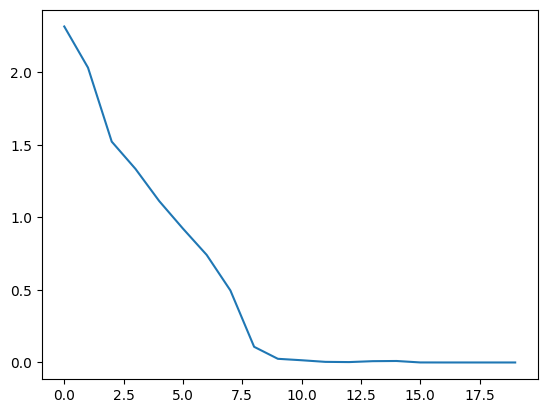

In [ ]:
plt.plot(dis_distances)

## Discrete with synthetic dataset

In [ ]:
vocab = {",": 10}
for i in range(10):
  key = str(i)
  value = i
  vocab[key] = value

In [ ]:
vocab

{',': 10,
 '0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [ ]:
anti_vocab = {}
for k in vocab:
  anti_vocab[vocab[k]] = k

In [ ]:
anti_vocab

{10: ',',
 0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

In [ ]:
test = " 8 , 9 , 1 0 , 1 1 , 1 2 ,"

In [ ]:
test.split()

['8', ',', '9', ',', '1', '0', ',', '1', '1', ',', '1', '2', ',']

In [ ]:
def tokenize(seq, vocab):
  # expect sequence like " 8 , 9 , 1 0 , 1 1 , 1 2 ,"
  splits = seq.split()
  res = [vocab[k] for k in splits]
  return torch.tensor(res)

In [ ]:
res = tokenize(test, vocab)

In [ ]:
res

tensor([ 8, 10,  9, 10,  1,  0, 10,  1,  1, 10,  1,  2, 10])

In [ ]:
res[: 4]

tensor([ 8, 10,  9, 10])

In [ ]:
acc = ""

In [ ]:
for i in range(98, 101):
  for c in str(i):
    acc += " " + c
  acc += " ,"

In [ ]:
acc

' 9 8 , 9 9 , 1 0 0 ,'

In [ ]:
def generate_sequence(length: int, tokenized_length: int, vocab, mini: int = 0, maxi: int = 100):
  start = random.randint(mini, maxi - length)
  end = start + length
  acc = ""
  for i in range(start, end+1):
    for c in str(i):
      acc += " " + c
    acc += " ,"
  tokenized = tokenize(acc, vocab)
  return tokenized[:tokenized_length]

In [ ]:
seq = generate_sequence(32, 32, vocab)

In [ ]:
seq

tensor([ 6,  5, 10,  6,  6, 10,  6,  7, 10,  6,  8, 10,  6,  9, 10,  7,  0, 10,
         7,  1, 10,  7,  2, 10,  7,  3, 10,  7,  4, 10,  7,  5])

In [ ]:
class DiscreteSynthetic(Dataset):
  def __init__(self, length: int = 32, tokenized_length: int = 32, vocab = {}, mini: int = 0, maxi: int = 100):
    assert vocab, "Vocab cannot be empty"
    self.length = length
    self.tokenized_length = tokenized_length
    self.vocab = vocab
    self.mini = mini
    self.maxi = maxi

  def __len__(self):
    return 10000

  def __getitem__(self, idx):
    return F.one_hot(generate_sequence(self.length, self.tokenized_length, self.vocab, self.mini, self.maxi), num_classes=len(self.vocab))

In [ ]:
max_seq_len = 32

In [ ]:
ds = DiscreteSynthetic(tokenized_length=max_seq_len, vocab=vocab)

In [ ]:
train_dl = DataLoader(ds, batch_size = 32 * 6 * 2)

In [ ]:
def make_infinite(dl):
  while True:
    for data in dl:
      yield data

In [ ]:
def make_output_readable(tensor, anti_vocab):
  batch_size, seq_len, num_classes = tensor.shape
  batches = []
  for i in range(batch_size):
    seq = tensor[i]
    cur_seq = []
    for j in range(seq_len):
      one_hot_encoding = seq[j]
      value = torch.argmax(one_hot_encoding)
      cur_seq.append(anti_vocab[int(value)])
    batches.append("".join(cur_seq))
  return batches

In [ ]:
# make_output_readable(example, anti_vocab)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = DiscreteModel(max_seq_len, len(vocab), 64, 8)

In [ ]:
model = model.to(device)

In [ ]:
opt = AdamW(model.parameters())

In [ ]:
losses = []

In [ ]:
train_dl = make_infinite(train_dl)

In [ ]:
def sample_t(batch_size, min_t=1e-6):
  return torch.clamp(torch.FloatTensor(batch_size).uniform_(0,1), min=min_t)

In [ ]:
sample_t(2)

tensor([0.7026, 0.4850])

In [ ]:
n = 100

In [ ]:
model_input = torch.normal(0, 1, (1, max_seq_len, len(vocab)))
model_input = torch.softmax(model_input, dim=-1) * 2 - 1

In [ ]:
with torch.no_grad():
  for i in range(1, n+1):
    cur_it = torch.tensor([i])
    total_it = torch.tensor([n])
    t = dis_t(cur_it,total_it)
    dis_beta_1 = torch.ones_like(t) * 4
    model_output = model.forward(model_input.to(device), t.to(device))
    model_input = dis_bayesian_inference(model_input.to('cpu'), model_output.to('cpu'), i, n, dis_beta_1, True)

In [ ]:
make_output_readable(model_input, anti_vocab)

['72278402628248422222228428222222']

In [ ]:
epochs = 1_000

In [ ]:
for i in tqdm(range(epochs)):
  opt.zero_grad()
  ground_truth = next(train_dl).to(device)
  batch_size, seq_len, classes = ground_truth.shape
  t = sample_t(batch_size).to(device)
  dis_beta_1 = torch.ones_like(t) * 4
  beta = dis_beta_t(dis_beta_1, t)
  y_prime = dis_y_distribution(beta, classes, ground_truth)
  theta = dis_theta(y_prime)

  dis_output = model.forward(theta, t)
  loss = dis_loss(classes, dis_beta_1, t, batch_size, ground_truth, model_output_logits=dis_output)
  loss.backward()
  opt.step()
  losses.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

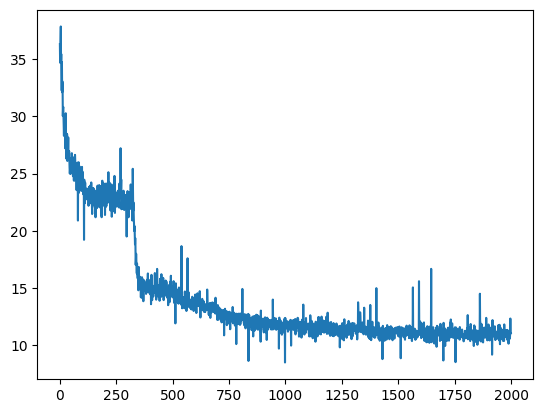

In [ ]:
plt.plot(losses)

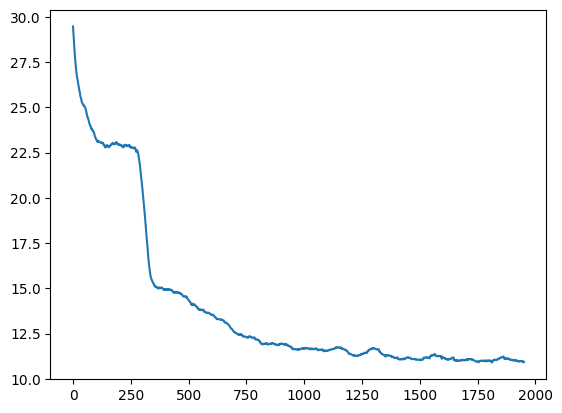

In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Usage
smoothed_losses = moving_average(losses, window_size=50)
plt.plot(smoothed_losses)

In [ ]:
model_input_og = torch.normal(0, 1, (1, max_seq_len, len(vocab))).to(device)
model_input_og = torch.softmax(model_input_og, dim=-1) * 2 - 1

In [ ]:
n = 190

In [ ]:
model_input = model_input_og

In [ ]:
for i in range(1, n+1):
  if i % 10 == 0:
    print(make_output_readable(model_input, anti_vocab))
  cur_it = torch.tensor([i])
  total_it = torch.tensor([n])
  t = dis_t(cur_it,total_it).to(device)
  dis_beta_1 = torch.ones_like(t) * 4
  model_output = model.forward(model_input, t)
  model_input = dis_bayesian_inference(model_input, model_output, i, n, dis_beta_1, True)

['3055404094,149,46,58,16440680,63']
['58759,49946,49,46,58,46,60712,64']
['58,42,40942,49,5,,58,57,58,12,59']
['59,52,75,41,59,59,58,51,56,52,59']
['58,55,5,,47,59,59,58,58,58,52,59']
['58,55,59,57,54,5,,58,52,59,59,59']
['58,55,59,57,54,58,58,52,59,59,56']
['59,55,50,57,54,59,58,52,59,59,56']
['59,59,59,55,54,59,52,54,53,59,58']
['59,59,53,59,54,53,52,58,59,55,58']
['59,54,53,56,54,53,54,58,59,55,58']
['59,55,53,56,58,53,52,55,59,55,58']
['59,55,53,54,58,53,52,55,59,55,58']
['59,55,53,54,54,53,52,55,59,55,58']
['59,55,53,54,54,53,52,58,59,55,58']
['54,55,54,54,54,53,52,55,59,55,58']
['54,55,50,54,54,53,52,55,58,55,58']
['55,55,50,54,54,53,59,55,58,56,58']
['55,55,50,54,54,53,59,55,58,55,58']
